# Deep Learning

## Assignment 7 

The objective of this assignment is to design and implement a deep learning model that learns to recognize sequences of digits.

First we use a synthetic dataset to run python experiments. The synthetic dataset is generated by concatenating character images from [notMNIST](http://yaroslavvb.blogspot.se/2011/09/notmnist-dataset.html) dataset.

In [1]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
from __future__ import print_function
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
import tarfile
from IPython.display import display
from PIL import Image
from scipy import ndimage
from sklearn.linear_model import LogisticRegression
from six.moves.urllib.request import urlretrieve
from six.moves import cPickle as pickle
import tensorflow as tf

# Config the matplotlib backend as plotting inline in IPython
%matplotlib inline

First, we'll download the dataset to our local machine. The data consists of characters rendered in a variety of fonts on a 28x28 image. The labels are limited to 'A' through 'J' (10 classes). The training set has about 500k and the testset 19000 labeled examples. Given these sizes, it should be possible to train models quickly on any machine.


In [2]:
url = 'https://commondatastorage.googleapis.com/books1000/'
last_percent_reported = None
data_root = '.' # Change me to store data elsewhere

def download_progress_hook(count, blockSize, totalSize):
  """A hook to report the progress of a download. This is mostly intended for users with
  slow internet connections. Reports every 5% change in download progress.
  """
  global last_percent_reported
  percent = int(count * blockSize * 100 / totalSize)

  if last_percent_reported != percent:
    if percent % 5 == 0:
      sys.stdout.write("%s%%" % percent)
      sys.stdout.flush()
    else:
      sys.stdout.write(".")
      sys.stdout.flush()
      
    last_percent_reported = percent
        
def maybe_download(filename, expected_bytes, force=False):
  """Download a file if not present, and make sure it's the right size."""
  dest_filename = os.path.join(data_root, filename)
  if force or not os.path.exists(dest_filename):
    print('Attempting to download:', filename) 
    filename, _ = urlretrieve(url + filename, dest_filename, reporthook=download_progress_hook)
    print('\nDownload Complete!')
  statinfo = os.stat(dest_filename)
  if statinfo.st_size == expected_bytes:
    print('Found and verified', dest_filename)
  else:
    raise Exception(
      'Failed to verify ' + dest_filename + '. Can you get to it with a browser?')
  return dest_filename

train_filename = maybe_download('notMNIST_large.tar.gz', 247336696)
test_filename = maybe_download('notMNIST_small.tar.gz', 8458043)

Found and verified .\notMNIST_large.tar.gz
Found and verified .\notMNIST_small.tar.gz


Extract the dataset from the compressed .tar.gz file. This should give you a set of directories, labeled A through J.


In [30]:
num_classes = 10
np.random.seed(133)

def maybe_extract(filename, force=False):
  root = os.path.splitext(os.path.splitext(filename)[0])[0]  # remove .tar.gz
  if os.path.isdir(root) and not force:
    # You may override by setting force=True.
    print('%s already present - Skipping extraction of %s.' % (root, filename))
  else:
    print('Extracting data for %s. This may take a while. Please wait.' % root)
    tar = tarfile.open(filename)
    sys.stdout.flush()
    tar.extractall(data_root)
    tar.close()
  data_folders = [
    os.path.join(root, d) for d in sorted(os.listdir(root))
    if os.path.isdir(os.path.join(root, d))]
  if len(data_folders) != num_classes:
    raise Exception(
      'Expected %d folders, one per class. Found %d instead.' % (
        num_classes, len(data_folders)))
  print(data_folders)
  return data_folders
  
train_folders = maybe_extract(train_filename)
test_folders = maybe_extract(test_filename)

.\notMNIST_large already present - Skipping extraction of .\notMNIST_large.tar.gz.
['.\\notMNIST_large\\A', '.\\notMNIST_large\\B', '.\\notMNIST_large\\C', '.\\notMNIST_large\\D', '.\\notMNIST_large\\E', '.\\notMNIST_large\\F', '.\\notMNIST_large\\G', '.\\notMNIST_large\\H', '.\\notMNIST_large\\I', '.\\notMNIST_large\\J']
.\notMNIST_small already present - Skipping extraction of .\notMNIST_small.tar.gz.
['.\\notMNIST_small\\A', '.\\notMNIST_small\\B', '.\\notMNIST_small\\C', '.\\notMNIST_small\\D', '.\\notMNIST_small\\E', '.\\notMNIST_small\\F', '.\\notMNIST_small\\G', '.\\notMNIST_small\\H', '.\\notMNIST_small\\I', '.\\notMNIST_small\\J']


Now let's load the data in a more manageable format. Since, depending on your computer setup you might not be able to fit it all in memory, we'll load each class into a separate dataset, store them on disk and curate them independently. Later we'll merge them into a single dataset of manageable size.

We'll convert the entire dataset into a 3D array (image index, x, y) of floating point values, normalized to have approximately zero mean and standard deviation ~0.5 to make training easier down the road.

A few images might not be readable, we'll just skip them.


In [31]:
image_size = 28  # Pixel width and height.
pixel_depth = 255.0  # Number of levels per pixel.

def load_letter(folder, min_num_images):
  """Load the data for a single letter label."""
  image_files = os.listdir(folder)
  dataset = np.ndarray(shape=(len(image_files), image_size, image_size),
                         dtype=np.float32)
  print(folder)
  num_images = 0
  for image in image_files:
    image_file = os.path.join(folder, image)
    try:
      image_data = (ndimage.imread(image_file).astype(float) - 
                    pixel_depth / 2) / pixel_depth
      if image_data.shape != (image_size, image_size):
        raise Exception('Unexpected image shape: %s' % str(image_data.shape))
      dataset[num_images, :, :] = image_data
      num_images = num_images + 1
    except IOError as e:
      print('Could not read:', image_file, ':', e, '- it\'s ok, skipping.')
    
  dataset = dataset[0:num_images, :, :]
  if num_images < min_num_images:
    raise Exception('Many fewer images than expected: %d < %d' %
                    (num_images, min_num_images))
    
  print('Full dataset tensor:', dataset.shape)
  print('Mean:', np.mean(dataset))
  print('Standard deviation:', np.std(dataset))
  return dataset
        
def maybe_pickle(data_folders, min_num_images_per_class, force=False):
  dataset_names = []
  for folder in data_folders:
    set_filename = folder + '.pickle'
    dataset_names.append(set_filename)
    if os.path.exists(set_filename) and not force:
      # You may override by setting force=True.
      print('%s already present - Skipping pickling.' % set_filename)
    else:
      print('Pickling %s.' % set_filename)
      dataset = load_letter(folder, min_num_images_per_class)
      try:
        with open(set_filename, 'wb') as f:
          pickle.dump(dataset, f, pickle.HIGHEST_PROTOCOL)
      except Exception as e:
        print('Unable to save data to', set_filename, ':', e)
  
  return dataset_names

train_datasets = maybe_pickle(train_folders, 45000)
test_datasets = maybe_pickle(test_folders, 1800)

.\notMNIST_large\A.pickle already present - Skipping pickling.
.\notMNIST_large\B.pickle already present - Skipping pickling.
.\notMNIST_large\C.pickle already present - Skipping pickling.
.\notMNIST_large\D.pickle already present - Skipping pickling.
.\notMNIST_large\E.pickle already present - Skipping pickling.
.\notMNIST_large\F.pickle already present - Skipping pickling.
.\notMNIST_large\G.pickle already present - Skipping pickling.
.\notMNIST_large\H.pickle already present - Skipping pickling.
.\notMNIST_large\I.pickle already present - Skipping pickling.
.\notMNIST_large\J.pickle already present - Skipping pickling.
.\notMNIST_small\A.pickle already present - Skipping pickling.
.\notMNIST_small\B.pickle already present - Skipping pickling.
.\notMNIST_small\C.pickle already present - Skipping pickling.
.\notMNIST_small\D.pickle already present - Skipping pickling.
.\notMNIST_small\E.pickle already present - Skipping pickling.
.\notMNIST_small\F.pickle already present - Skipping pi

Merge and prune the training data as needed. Depending on your computer setup, you might not be able to fit it all in memory, and you can tune `train_size` as needed. The labels will be stored into a separate array of integers 0 through 9.

Also create a validation dataset for hyperparameter tuning.

In [32]:
def make_arrays(nb_rows, img_size):
  if nb_rows:
    dataset = np.ndarray((nb_rows, img_size, img_size), dtype=np.float32)
    labels = np.ndarray(nb_rows, dtype=np.int32)
  else:
    dataset, labels = None, None
  return dataset, labels

def merge_datasets(pickle_files, train_size, valid_size=0):
  num_classes = len(pickle_files)
  valid_dataset, valid_labels = make_arrays(valid_size, image_size)
  train_dataset, train_labels = make_arrays(train_size, image_size)
  vsize_per_class = valid_size // num_classes
  tsize_per_class = train_size // num_classes
    
  start_v, start_t = 0, 0
  end_v, end_t = vsize_per_class, tsize_per_class
  end_l = vsize_per_class+tsize_per_class
  for label, pickle_file in enumerate(pickle_files):       
    try:
      with open(pickle_file, 'rb') as f:
        letter_set = pickle.load(f)
        # let's shuffle the letters to have random validation and training set
        np.random.shuffle(letter_set)
        if valid_dataset is not None:
          valid_letter = letter_set[:vsize_per_class, :, :]
          valid_dataset[start_v:end_v, :, :] = valid_letter
          valid_labels[start_v:end_v] = label
          start_v += vsize_per_class
          end_v += vsize_per_class
                    
        train_letter = letter_set[vsize_per_class:end_l, :, :]
        train_dataset[start_t:end_t, :, :] = train_letter
        train_labels[start_t:end_t] = label
        start_t += tsize_per_class
        end_t += tsize_per_class
    except Exception as e:
      print('Unable to process data from', pickle_file, ':', e)
      raise
    
  return valid_dataset, valid_labels, train_dataset, train_labels
            
            
train_size = 450000
valid_size = 30000
test_size = 15000

valid_dataset, valid_labels, train_dataset, train_labels = merge_datasets(
  train_datasets, train_size, valid_size)
_, _, test_dataset, test_labels = merge_datasets(test_datasets, test_size)
9
print('Training:', train_dataset.shape, train_labels.shape)
print('Validation:', valid_dataset.shape, valid_labels.shape)
print('Testing:', test_dataset.shape, test_labels.shape)

Training: (450000, 28, 28) (450000,)
Validation: (30000, 28, 28) (30000,)
Testing: (15000, 28, 28) (15000,)


Next, we'll randomize the data. It's important to have the labels well shuffled for the training and test distributions to match.

In [33]:
def randomize(dataset, labels):
  permutation = np.random.permutation(labels.shape[0]) 
  shuffled_dataset = dataset[permutation,:,:]
  shuffled_labels = labels[permutation]
  return shuffled_dataset, shuffled_labels
train_dataset, train_labels = randomize(train_dataset, train_labels)
test_dataset, test_labels = randomize(test_dataset, test_labels)
valid_dataset, valid_labels = randomize(valid_dataset, valid_labels)

Let's see if the data is still good after shuffling.

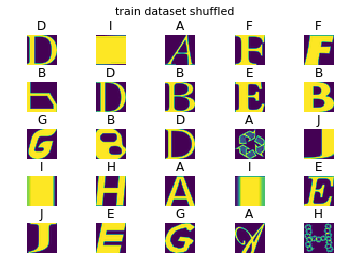

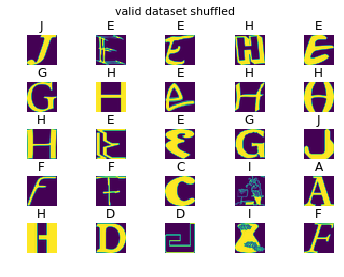

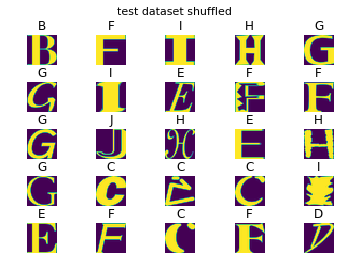

In [34]:
import random

def plot_sample_dataset(dataset, labels, title = None):
    if title:
        plt.suptitle(title, fontsize = 11)
    
    sample_items = random.sample(range(len(labels)),25)
    for index,item in enumerate(sample_items):
        plt.subplot(5,5,index + 1)
        plt.subplots_adjust(wspace = 0.2, hspace = 0.6)
        plt.title(chr(ord('A') + labels[item]))
        plt.axis('off')
        plt.imshow(dataset[item])
    plt.show()
    
plot_sample_dataset(train_dataset, train_labels, 'train dataset shuffled')
plot_sample_dataset(valid_dataset, valid_labels, 'valid dataset shuffled')        
plot_sample_dataset(test_dataset, test_labels, 'test dataset shuffled')
        

Save dataset for later use:

In [35]:
pickle_file = os.path.join(data_root, 'notMNIST.pickle')

if os.path.exists(pickle_file):
      print('%s already present - Skipping pickling.' % pickle_file)
else:
    try:
      f = open(pickle_file, 'wb')
      save = {
        'train_dataset': train_dataset,
        'train_labels': train_labels,
        'valid_dataset': valid_dataset,
        'valid_labels': valid_labels,
        'test_dataset': test_dataset,
        'test_labels': test_labels,
        }
      pickle.dump(save, f, pickle.HIGHEST_PROTOCOL)
      f.close()
    except Exception as e:
      print('Unable to save data to', pickle_file, ':', e)
      raise

.\notMNIST.pickle already present - Skipping pickling.


We will concatenate 3 images together to create a synthetic dataset. # The corresponding label for synthetic dataset are syn_label = a*10^(num_concat -1) + b*10^(num_concat -2) + ... + last_label*(10^0)

In [38]:
num_concat = 3 # concatenate 3 images together

'''
def create_synthetic_dataset(dataset, labels, num_concat):
    len_syn_dataset = dataset.shape[0]//num_concat
    syn_dataset = np.ndarray((len_syn_dataset, image_size, image_size*3), dtype = np.float32)
    syn_labels = np.ndarray(len_syn_dataset, dtype = np.int32)
    for i in range(len_syn_dataset):
        syn_dataset[i] = np.concatenate((dataset[i*num_concat:(i+1)*num_concat]), axis = 1)
        label_temp = 0
        for index in range(num_concat):
            label_temp += labels[i*num_concat + index] * np.power(10,num_concat-index-1)
        syn_labels[i] = label_temp
    return syn_dataset, syn_labels
'''

def create_synthetic_dataset(dataset, labels, num_concat):
    len_syn_dataset = dataset.shape[0]//num_concat
    syn_dataset = np.ndarray((len_syn_dataset, image_size, image_size*3), dtype = np.float32)
    syn_length_labels = np.ndarray(len_syn_dataset, dtype = np.int32)
    syn_length_labels.fill(3)
    syn_digits_labels = np.ndarray([len_syn_dataset, num_concat], dtype = np.int32)
    
    for i in range(len_syn_dataset):
        syn_dataset[i] = np.concatenate((dataset[i*num_concat:(i+1)*num_concat]), axis = 1)
        for index in range(num_concat):
            syn_digits_labels[i][index] = labels[i*num_concat + index]
    return syn_dataset, syn_length_labels, syn_digits_labels

syn_train_dataset, syn_train_length_labels, syn_train_digits_labels = create_synthetic_dataset(
    train_dataset, train_labels, num_concat)
syn_valid_dataset, syn_valid_length_labels, syn_valid_digits_labels = create_synthetic_dataset(
    valid_dataset, valid_labels, num_concat)
syn_test_dataset, syn_test_length_labels, syn_test_digits_labels = create_synthetic_dataset(
    test_dataset, test_labels, num_concat)
    
print('Training synthetic dataset:', syn_train_dataset.shape, syn_train_length_labels.shape,
      syn_train_digits_labels.shape)
print('Valid synthetic dataset:', syn_valid_dataset.shape, syn_valid_length_labels.shape,
      syn_valid_digits_labels.shape)
print('Test synthetic dataset:', syn_test_dataset.shape, syn_test_length_labels.shape,
      syn_test_digits_labels.shape)

Training synthetic dataset: (150000, 28, 84) (150000,) (150000, 3)
Valid synthetic dataset: (10000, 28, 84) (10000,) (10000, 3)
Test synthetic dataset: (5000, 28, 84) (5000,) (5000, 3)


Show some data to see if the synthetic dataset are good.

In [5]:
import random
num_concat = 3 # concatenate 3 images together

def plot_sample_dataset(dataset, length_labels, digits_labels, title = None):
    if title:
        plt.suptitle(title, fontsize = 11)
    
    sample_items = random.sample(range(len(length_labels)),25)
    for index,item in enumerate(sample_items):
        plt.subplot(5,5,index + 1)
        plt.subplots_adjust(wspace = 0.2, hspace = 0.6)
        
        label_temp_str = ''
        '''
        label_temp_int = labels[item]
        for i in range(num_concat):
            label_temp_str += chr(ord('A') + 
                                  label_temp_int//(np.power(10,num_concat-i-1)))
            label_temp_int = label_temp_int%(np.power(10,num_concat-i-1))  
        '''
        for i in range(length_labels[item]):
            label_temp_str += chr(ord('A') + digits_labels[item][i])

        plt.title(label_temp_str)
        plt.axis('off')
        plt.imshow(dataset[item])
    plt.show()

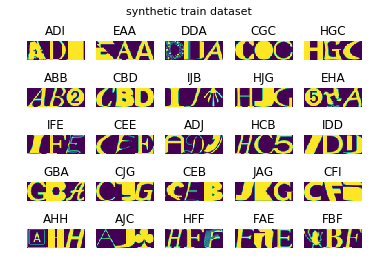

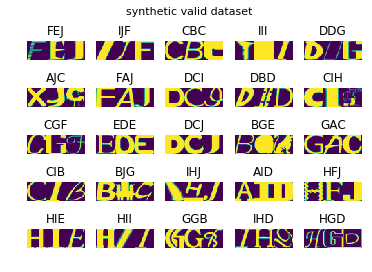

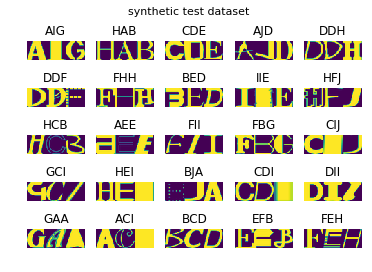

In [6]:
plot_sample_dataset(syn_train_dataset, syn_train_length_labels, 
                    syn_train_digits_labels, 'synthetic train dataset')
plot_sample_dataset(syn_valid_dataset, syn_valid_length_labels, 
                    syn_valid_digits_labels, 'synthetic valid dataset')        
plot_sample_dataset(syn_test_dataset, syn_test_length_labels,
                    syn_test_digits_labels, 'synthetic test dataset')

Let's save the data to use later:

In [43]:
pickle_file = os.path.join(data_root, 'syn_notMNIST.pickle')

if os.path.exists(pickle_file):
      print('%s already present - Skipping pickling.' % pickle_file)
else:
    try:
      f = open(pickle_file, 'wb')
      save = {
        'syn_train_dataset': syn_train_dataset,
        'syn_train_length_labels': syn_train_length_labels,
        'syn_train_digits_labels': syn_train_digits_labels,
          
        'syn_valid_dataset': syn_valid_dataset,
        'syn_valid_length_labels': syn_valid_length_labels,
        'syn_valid_digits_labels': syn_valid_digits_labels,
          
        'syn_test_dataset': syn_test_dataset,
        'syn_test_length_labels': syn_test_length_labels,
        'syn_test_digits_labels': syn_test_digits_labels,
        }
      pickle.dump(save, f, pickle.HIGHEST_PROTOCOL)
      f.close()
    except Exception as e:
      print('Unable to save data to', pickle_file, ':', e)
      raise

Get dataset from pickle file:

In [101]:
pickle_file = 'syn_notMNIST.pickle'

with open(pickle_file, 'rb') as f:
  save = pickle.load(f)
  syn_train_dataset = save['syn_train_dataset']
  syn_train_length_labels = save['syn_train_length_labels']
  syn_train_digits_labels = save['syn_train_digits_labels']
  
  syn_valid_dataset = save['syn_valid_dataset']
  syn_valid_length_labels = save['syn_valid_length_labels']
  syn_valid_digits_labels = save['syn_valid_digits_labels']
    
  syn_test_dataset = save['syn_test_dataset']
  syn_test_length_labels = save['syn_test_length_labels']
  syn_test_digits_labels = save['syn_test_digits_labels']
  del save  # hint to help gc free up memory
  print('Training synthetic dataset:', syn_train_dataset.shape, syn_train_length_labels.shape,
      syn_train_digits_labels.shape)
  print('Valid synthetic dataset:', syn_valid_dataset.shape, syn_valid_length_labels.shape,
      syn_valid_digits_labels.shape)
  print('Test synthetic dataset:', syn_test_dataset.shape, syn_test_length_labels.shape,
      syn_test_digits_labels.shape)

Training synthetic dataset: (150000, 28, 84) (150000,) (150000, 3)
Valid synthetic dataset: (10000, 28, 84) (10000,) (10000, 3)
Test synthetic dataset: (5000, 28, 84) (5000,) (5000, 3)


Reformat into a TensorFlow-friendly shape:
- convolutions need the image data formatted as a cube (width by height by #channels)
- labels as float 1-hot encodings.

In [102]:
image_size = 28
#num_labels = 1000 # 000 - 999
num_length_labels = 5 # 0-3, and >3
num_digits_labels = 10 # 0-9
num_channels = 1 #grayscale
in_height = image_size
in_width = image_size*3

def reformat(dataset, length_labels, digits_labels):
  dataset = dataset.reshape(
    (-1, in_height, in_width, num_channels)).astype(np.float32)

  length_labels = (np.arange(num_length_labels) == length_labels[:,None]).astype(np.float32)
  length_labels = np.squeeze(length_labels)

  digits_labels = (np.arange(num_digits_labels) == digits_labels[:,:,None]).astype(np.float32)
  digits_labels = np.squeeze(digits_labels)

  return dataset, length_labels, digits_labels

syn_train_dataset, syn_train_length_labels, syn_train_digits_labels = reformat(
    syn_train_dataset, syn_train_length_labels, syn_train_digits_labels)
syn_valid_dataset, syn_valid_length_labels, syn_valid_digits_labels = reformat(
    syn_valid_dataset, syn_valid_length_labels, syn_valid_digits_labels)
syn_test_dataset, syn_test_length_labels, syn_test_digits_labels = reformat(
    syn_test_dataset, syn_test_length_labels, syn_test_digits_labels)

print('Training synthetic dataset:', syn_train_dataset.shape, syn_train_length_labels.shape,
      syn_train_digits_labels.shape)
print('Valid synthetic dataset:', syn_valid_dataset.shape, syn_valid_length_labels.shape,
      syn_valid_digits_labels.shape)
print('Test synthetic dataset:', syn_test_dataset.shape, syn_test_length_labels.shape,
      syn_test_digits_labels.shape)

Training synthetic dataset: (150000, 28, 84, 1) (150000, 5) (150000, 3, 10)
Valid synthetic dataset: (10000, 28, 84, 1) (10000, 5) (10000, 3, 10)
Test synthetic dataset: (5000, 28, 84, 1) (5000, 5) (5000, 3, 10)


In [103]:
# all digits has be correct to be considered as accurate
def accuracy(length_predictions, length_labels, digits_predictions, digits_labels):
    accuracy = 0
    for index in range(length_predictions.shape[0]):
        accuracy += np.prod(np.argmax(digits_predictions[index], 1) == np.argmax(digits_labels[index], 1))
        # *(np.argmax(length_predictions[index]) == np.argmax(length_labels[index]))
    accuracy = 100.0 * accuracy / length_predictions.shape[0]
    
    return accuracy

Let's build a small network with 2*(convolution layer + max pooling), followed by 2 fully connected layers, with L2 regulation to prevent overfitting.

In [142]:
batch_size = 16
patch_size = 5
depth_1 = 16
depth_2 = 32
num_hidden_1 = 64
num_hidden_2 = 128
decay_steps = 10000
decay_rate = 0.95
#keep_prop = 0.9

graph = tf.Graph()

with graph.as_default():
    
    # Input data
    tf_train_dataset = tf.placeholder(
        tf.float32, shape = (batch_size, in_height, in_width, num_channels))
    tf_train_length_labels = tf.placeholder(tf.float32, shape = (batch_size, num_length_labels))
    tf_train_digits_labels = tf.placeholder(tf.float32, shape = (
        batch_size, num_concat, num_digits_labels))
    tf_valid_dataset = tf.constant(syn_valid_dataset)
    tf_test_dataset = tf.constant(syn_test_dataset)
    tf_beta_regul = tf.placeholder(tf.float32)
    
    global_step = tf.Variable(0) # count number of steps taken
    
    # Variables
    # CNN variables
    layer1_w = tf.Variable(tf.truncated_normal(
        [patch_size, patch_size, num_channels, depth_1], stddev = 0.3*np.sqrt(
            2.0/(patch_size*patch_size*num_channels))))
    layer1_b = tf.Variable(tf.zeros([depth_1]))
    
    layer2_w = tf.Variable(tf.truncated_normal(
        [patch_size, patch_size, depth_1, depth_2], stddev = 0.3*np.sqrt(
            2.0/(patch_size*patch_size*depth_1))))
    layer2_b = tf.Variable(tf.zeros([depth_2]))
    
    # Fully connected layers variables
    layer3_w = tf.Variable(tf.truncated_normal(
        [(in_height//4)*(in_width//4)*depth_2, num_hidden_1], stddev = 0.3*np.sqrt(
            2.0/((in_height//4)*(in_width//4)*depth_2))))
    layer3_b = tf.Variable(tf.zeros([num_hidden_1]))
    
    layer4_w = tf.Variable(tf.truncated_normal(
        [num_hidden_1,num_hidden_2], stddev = 0.3*np.sqrt(2.0/num_hidden_1)))
    layer4_b = tf.Variable(tf.zeros([num_hidden_2]))
    
    # individual fully connected layers variables for length and each digit
    length_w = tf.Variable(tf.truncated_normal(
        [num_hidden_2, num_length_labels], stddev = 0.3*np.sqrt(2.0/num_hidden_2)))
    length_b = tf.Variable(tf.zeros([num_length_labels]))
    
    d1_w = tf.Variable(tf.truncated_normal(
        [num_hidden_2, num_digits_labels], stddev = 0.3*np.sqrt(2.0/num_hidden_2)))
    d1_b = tf.Variable(tf.zeros([num_digits_labels]))
    
    d2_w = tf.Variable(tf.truncated_normal(
        [num_hidden_2, num_digits_labels], stddev = 0.3*np.sqrt(2.0/num_hidden_2)))
    d2_b = tf.Variable(tf.zeros([num_digits_labels]))
    
    d3_w = tf.Variable(tf.truncated_normal(
        [num_hidden_2, num_digits_labels], stddev = 0.3*np.sqrt(2.0/num_hidden_2)))
    d3_b = tf.Variable(tf.zeros([num_digits_labels]))
    
    # Model
    def model(data):
        # convolution 1
        conv = tf.nn.conv2d(data, layer1_w, [1,1,1,1], padding = 'SAME')
        # relu
        hidden = tf.nn.relu(conv + layer1_b)
        
        # max pooling 1
        max_pool = tf.nn.max_pool(hidden, ksize = [1,2,2,1], strides = [1,2,2,1], padding = 'SAME')
        dropout = max_pool
        #dropout = tf.nn.dropout(max_pool, keep_prob = keep_prop)
        
        
        # convolution 2
        conv = tf.nn.conv2d(dropout, layer2_w, [1,1,1,1], padding = 'SAME')
        #relu
        hidden = tf.nn.relu(conv + layer2_b)
        
        # max pooling 2
        max_pool = tf.nn.max_pool(hidden, ksize = [1,2,2,1], strides = [1,2,2,1], padding = 'SAME')
        dropout = max_pool
        #dropout = tf.nn.dropout(max_pool, keep_prob = keep_prop)
        
        # reshape
        shape = dropout.get_shape().as_list()
        reshape = tf.reshape(dropout,[shape[0], shape[1]*shape[2]*shape[3]])
        
        # fully connected 1
        y1 = tf.nn.relu(tf.matmul(reshape, layer3_w) + layer3_b)
        
        # fully connected 2
        y2 = tf.nn.relu(tf.matmul(y1, layer4_w) + layer4_b)
        
        # length logits
        length_logits = tf.matmul(y2, length_w) + length_b
        
        # logits for each digits
        d1_logits = tf.matmul(y2, d1_w) + d1_b
        d2_logits = tf.matmul(y2, d2_w) + d2_b
        d3_logits = tf.matmul(y2, d3_w) + d3_b
        
        digits_logits = tf.stack([d1_logits, d2_logits, d3_logits], axis = 1)
        
        return length_logits, digits_logits
    
    # Training computation
    length_logits, digits_logits = model(tf_train_dataset)
    
    length_loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(
        logits = length_logits, labels = tf_train_length_labels))
    digit1_loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(
        logits = digits_logits[:,0,:], labels = tf_train_digits_labels[:,0,:]))
    digit2_loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(
        logits = digits_logits[:,1,:], labels = tf_train_digits_labels[:,1,:]))
    digit3_loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(
        logits = digits_logits[:,2,:], labels = tf_train_digits_labels[:,2,:]))
    l2_loss = tf_beta_regul*(tf.nn.l2_loss(layer3_w) + tf.nn.l2_loss(layer4_w))
    
    loss = length_loss + digit1_loss + digit2_loss + digit3_loss + l2_loss
    
    # Learning rate
    learning_rate = tf.train.exponential_decay(0.01, global_step, decay_steps, decay_rate)
    
    # Optimizer
    optimizer = tf.train.GradientDescentOptimizer(
        learning_rate).minimize(loss, global_step = global_step)
    
    # Predictions for training, validation, and test data
    train_length_prediction = tf.nn.softmax(length_logits)
    train_digits_prediction = tf.nn.softmax(digits_logits)
    valid_length_prediction = tf.nn.softmax(model(tf_valid_dataset)[0])
    valid_digits_prediction = tf.nn.softmax(model(tf_valid_dataset)[1])
    test_length_prediction = tf.nn.softmax(model(tf_test_dataset)[0])
    test_digits_prediction = tf.nn.softmax(model(tf_test_dataset)[1])

In [143]:
num_steps = 100001
num_step = []
validation_accuracy = []
beta_regul = 0.00055
total_loss = []

with tf.Session(graph = graph) as session:
    tf.global_variables_initializer().run()
    print('Initialized')
    for step in range(num_steps):
        offset = (step * batch_size) % (syn_train_length_labels.shape[0] - batch_size)
        batch_data = syn_train_dataset[offset:(offset + batch_size), :, :, :]
        batch_length_labels = syn_train_length_labels[offset:(offset + batch_size), :]
        batch_digits_labels = syn_train_digits_labels[offset:(offset + batch_size), :, :]
        feed_dict = {tf_train_dataset: batch_data,
                    tf_train_length_labels: batch_length_labels,
                    tf_train_digits_labels: batch_digits_labels,
                    tf_beta_regul: beta_regul}
        _, l, length_prediction, digits_prediction = session.run(
            [optimizer, loss, train_length_prediction, train_digits_prediction], feed_dict = feed_dict)
        
        # print out progress
        if(step % 500 == 0):
            num_step.append(step)
            validation_accuracy.append(accuracy(
                valid_length_prediction.eval(), syn_valid_length_labels, 
                valid_digits_prediction.eval(), syn_valid_digits_labels))
            total_loss.append(l)
            
            print('Minibatch loss at step %d: %f' % (step, l))
            print('Minibatch accuracy: %.1f%%' % accuracy(length_prediction, batch_length_labels, 
                                                          digits_prediction, batch_digits_labels))
            print('Validation accuracy: %.1f%%' % accuracy(
                valid_length_prediction.eval(), syn_valid_length_labels, 
                valid_digits_prediction.eval(), syn_valid_digits_labels))
        if(step % 10000 == 0):
            print('Test accuracy: %.1f%%' % accuracy(test_length_prediction.eval(), syn_test_length_labels, 
                test_digits_prediction.eval(), syn_test_digits_labels))
            # this is an aggressive way of getting prediction results
            test_length_result = np.argmax(test_length_prediction.eval(), axis = 1)
            test_digits_result = np.argmax(test_digits_prediction.eval(), axis = 2)

    

Initialized
Minibatch loss at step 0: 8.524814
Minibatch accuracy: 0.0%
Validation accuracy: 0.1%
Test accuracy: 0.1%
Minibatch loss at step 500: 6.849119
Minibatch accuracy: 0.0%
Validation accuracy: 0.1%
Minibatch loss at step 1000: 4.649495
Minibatch accuracy: 12.5%
Validation accuracy: 6.7%
Minibatch loss at step 1500: 4.141620
Minibatch accuracy: 37.5%
Validation accuracy: 29.1%
Minibatch loss at step 2000: 3.183609
Minibatch accuracy: 37.5%
Validation accuracy: 40.0%
Minibatch loss at step 2500: 2.191531
Minibatch accuracy: 50.0%
Validation accuracy: 49.9%
Minibatch loss at step 3000: 2.017932
Minibatch accuracy: 56.2%
Validation accuracy: 53.3%
Minibatch loss at step 3500: 1.878336
Minibatch accuracy: 62.5%
Validation accuracy: 55.0%
Minibatch loss at step 4000: 1.562243
Minibatch accuracy: 68.8%
Validation accuracy: 55.5%
Minibatch loss at step 4500: 1.311933
Minibatch accuracy: 50.0%
Validation accuracy: 59.4%
Minibatch loss at step 5000: 1.440261
Minibatch accuracy: 62.5%
Val

KeyboardInterrupt: 

Plot test result samples and validation accuracy:

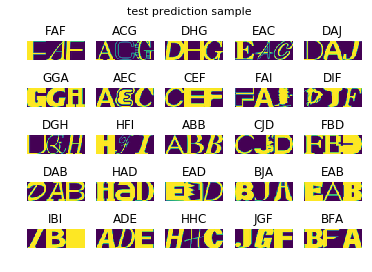

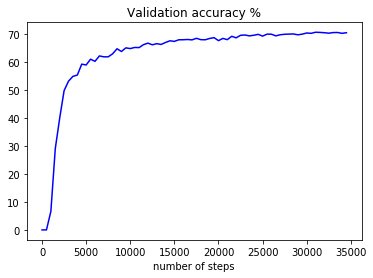

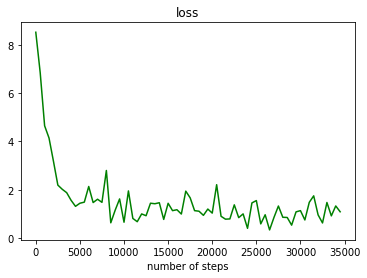

In [144]:
syn_test_dataset_temp = np.squeeze(syn_test_dataset)
plot_sample_dataset(syn_test_dataset_temp, test_length_result, 
                    test_digits_result, 'test prediction sample')

plt.plot(num_step, validation_accuracy, 'b-')
plt.title('Validation accuracy %')
plt.xlabel('number of steps')
plt.show()

plt.plot(num_step, total_loss, 'g-')
plt.title('loss')
plt.xlabel('number of steps')
plt.show()